# <span style='background-color: #fff5b1'>오늘의 한 걸음  🚶🏽‍♂️: Trand 와 Seasonality 를 감안해 주가 예측하기!</span>

## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. 
### -     GAME#1 삼성전자 주가 데이터
    2-1. 데이터 읽어오기  
    2-2. 데이터 전처리  
        -1. 결측치 제거
        -2. Normalization
        -3. 시계열 안정성 분석
        -4. train, test split
        
    2-3. 모델 학습  
    2-4. 데이터 평가 
    
### -     GAME#2 카카오 주가 데이터
    2-1. 데이터 읽어오기  
    2-2. 데이터 전처리  
        -1. 결측치 제거
        -2. Normalization
        -3. 시계열 안정성 분석
        -4. train, test split
        
    2-3. 모델 학습  
    2-4. 데이터 평가 

### -     GAME#3 도미노피자 주가 데이터
    2-1. 데이터 읽어오기  
    2-2. 데이터 전처리  
        -1. 결측치 제거
        -2. Normalization
        -3. 시계열 안정성 분석
        -4. train, test split
        
    2-3. 모델 학습  
    2-4. 데이터 평가 
    
    
### 3. POTG (best Play Of The Game
    3-1. 소감(POTG)  
    3-2. 어려웠던 점과 극복방안  
    3-3. 추후  

---


# 1. Ready
## 1-1. 오늘의 Exp와 Rubric


오늘은 Time-Series (시계열 데이터) 를 다루는 ARIMA 기법을 통해  
우리나라 대장주 삼성전자의 주식 시세를 예측한다.

ARIMA 기법이란,  

1. AR (AutoRegressive)
2. I(Intergragted)
3. MA (Moving Average) 

를 사용한 통계 기법이다.

AR 은 시계열의 Residual 에 해당하는 모델이다.  
주식값이 항상 일정한 균형 수준을 유지할 것이라고 예측하는 관점이다.

I 는 미래의 결과가 d차 차분의 누적(intergration) 합이라고 본다.  

MA 는 이동평균을 구해 시계열의 Trend 값을 구한다.
주식값이 최근의 증감 패턴을 지속할 것이라고 보는 관점이다.

때문에 **AR 값이 높으면**  
> 가격이 그대로일 것이다.

**MA 값이 높으면**  
> 지금 오르는(내리는)방향으로 쭉 이동할 것이다.

라는 추세를 보여준다.

---

삼성의 주식 데이터는 해당 링크에서 csv타입 형태로 찾을 수 있다.

[[Yahoo!-finacne 링크]](https://finance.yahoo.com/quote/005930.KS?p=005930.KS)

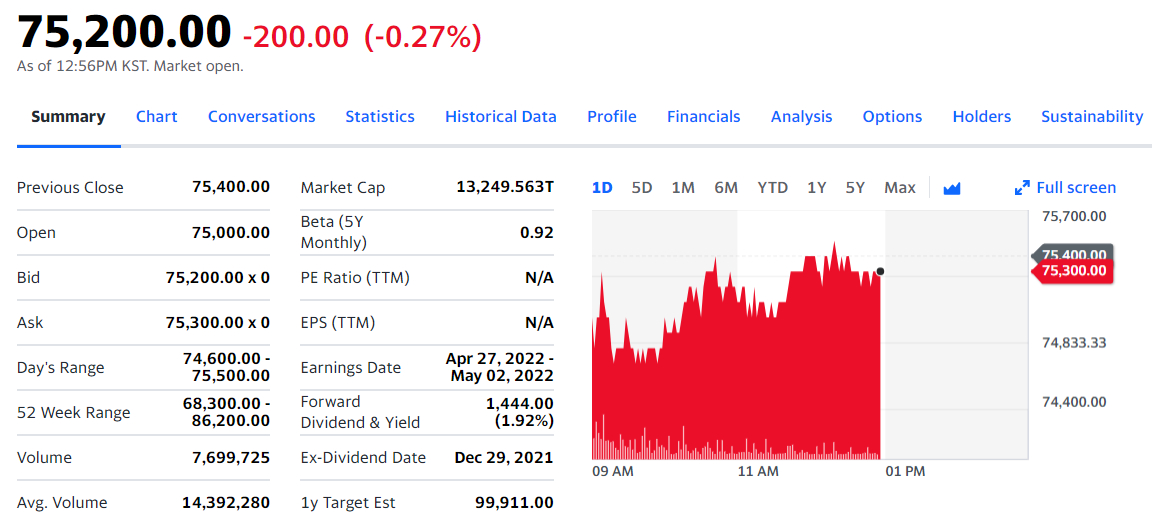

어느새 75000원까지 오른 삼성,,


해당 데이터를 다운로드하면

Date  
Open 시작가  
High 그날 최고가  
Low 그날 최저가  
Close 종료가  
Adj close 수정종가  
Volume 거래량  

총 7개의 column 으로 구성되어 있다.

이 중 우리는 일단 단순하게 

Date 와 Close 데이터를 이용해 주식가격을 예측해 보도록 한다.

## 1-2. 사용하는 라이브러리

In [1]:
import os #경로 설정 라이브러리

import numpy as np
import pandas as pd #배열을 다루는 라이브러리

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams #시각화 라이브러리


from statsmodels.tsa.stattools import adfuller # 통계 분석 라이브러리
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
#ARIMA 측정 지표 그래프 생성 라이브러리

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math #데이터 복원을 위한 수학 라이브러리

import warnings
warnings.filterwarnings('ignore') 

print('슝=3')

슝=3


# 2. GAME#1 삼성 주가 분석
## 2-1. 데이터 읽어오기

In [3]:
dataset_filepath = os.getenv('HOME')+'/aiffel/workplace/E11/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


이 중 우리가 필요한 Close 값만 꺼내 온다면

In [4]:
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True )
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [5]:
ts.tail()

Date
2021-05-12    80000.0
2021-05-13    78500.0
2021-05-14    80100.0
2021-05-17    79600.0
2021-05-18    79600.0
Name: Close, dtype: float64

`parse_dates` : 데이터가 시간값이라는 것을 알림

date 열을 index 로 받았고,  
Close Columns 하나만 가져와 Series 타입을 불러 왔다.

자료를 보니 2020년 5월 부터 2021년 5월까지의 1년 데이터를 가지고 있다.

## 2-2.데이터 전처리

### 2-2-1. 결측치 제거

In [6]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

결측치는 없는 것으로 보인다.

### 2-2-2. Normalization

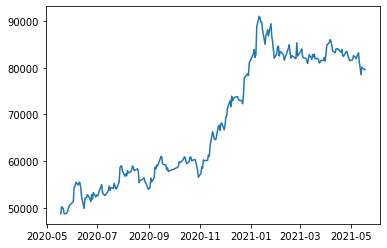

In [7]:
plt.plot(ts)

삼성 주식은 2020년 5월 48000원부터 2021년 5월 80000원 까지 무려 3만원이 올랐다

다만, 우리가 시계열 예측을 하기 위해선 해당 Series 데이터는

`Stationary` 한 특징을 가지고 있어야 한다.

#### Stationary 하다는 말은?

1. 일정한 평균
2. 일정한 분산
3. 일정한 공분산

상단의 데이터는 현재 Non-stationary  하기 때문에  
로그를 사용해 데이터 분포를 Normalization 한다.



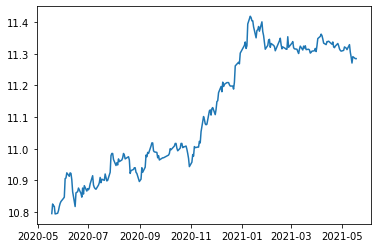

In [8]:
ts_log = np.log(ts)
plt.plot(ts_log)

세로 값이 90,000 에서 11.4 로 변함을 알 수 있다.

### 2-2-3. 시계열 안정성 분석

시계열이 stationary 한지 알아보기 위해서는  
다양한 방법이 있지만, 우리가 사용할 검증 방법은

DIckey-Fuller Test 이다.

자세한 내용은 생략하고, 이 검증방법을 통해 

p-value 가 설정한 유의수준 값(0.05) 보다 작으면 

Stationary 라고 할 수 있다.

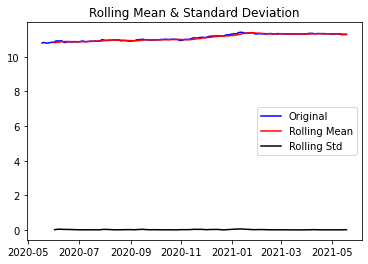

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


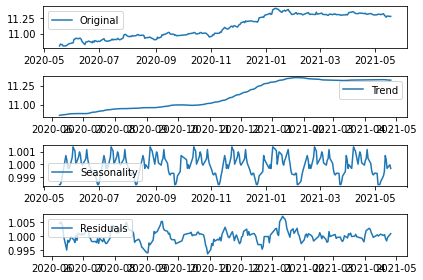

In [9]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    


def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()



단순 로그만 취한 데이터는  
p-value 값이 0.5 보다 크므로 seasonary하다고 말할 수 없다.

허나 Arima 기법을 통해 Trend 와 Seasonality 성질을 제거한  
residual 값을 사용한다면.  

seasonary 하게 변형할 수 있다.




In [51]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### 2-2-4. train, test split

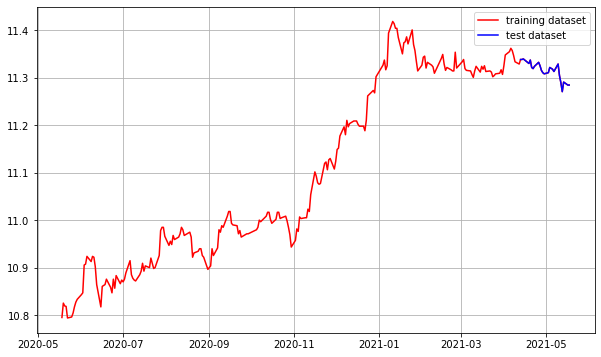

In [52]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

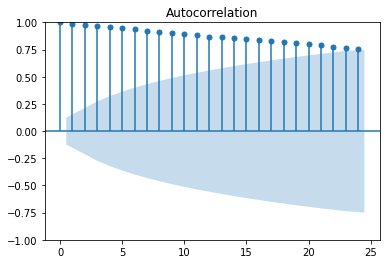

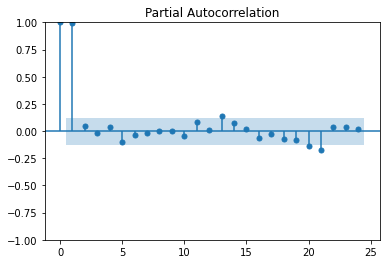

In [53]:

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


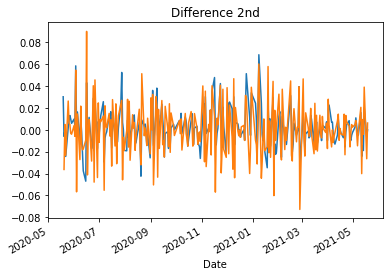

In [54]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## 2-3.모델 학습

전처리 시 구한 p, q ,d 를 이용해 ARIMA 기법을 이용해 데이터를 예측한다.

In [55]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(20, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(20, 0, 1)   Log Likelihood                 588.776
Date:                Fri, 11 Feb 2022   AIC                          -1131.551
Time:                        05:49:44   BIC                          -1052.981
Sample:                             0   HQIC                         -1099.840
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0576      0.144     77.049      0.000      10.776      11.339
ar.L1          0.6538      2.601      0.251      0.802      -4.444       5.752
ar.L2          0.3444      2.707      0.127      0.8

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


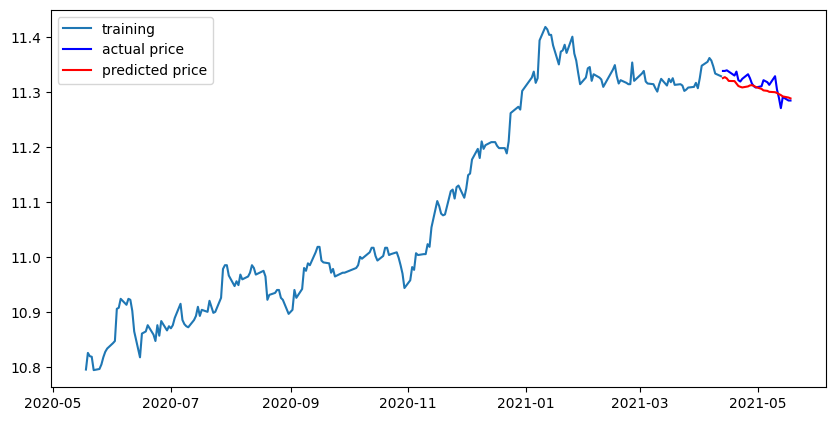

In [56]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


## 2-4.데이터 평가

In [57]:


mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1296699.7743361653
MAE:  957.9110461055394
RMSE:  1138.727260732861
MAPE: 1.16%


최종 예측으로 MAPE 를 측정해 봤을 때,   
1.16% 로 훌륭하게 적은 오차율이 나왔다!

# 2. GAME#2 카카오 주가 데이터

## 2-1. 데이터 읽어오기

In [58]:
dataset_filepath = os.getenv('HOME')+'/aiffel/workplace/E11/stock_prediction/data/035720.KS.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-15,99800.0,101000.0,98400.0,100400.0,100400.0,5262740
1,2021-02-16,100800.0,103800.0,99900.0,102800.0,102800.0,5380240
2,2021-02-17,103000.0,103000.0,100600.0,101800.0,101800.0,2812860
3,2021-02-18,101200.0,103400.0,100200.0,100200.0,100200.0,2334610
4,2021-02-19,99400.0,101200.0,98000.0,100800.0,100800.0,3478320


In [59]:
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True )
ts = df['Close']

ts.head()

Date
2021-02-15    100400.0
2021-02-16    102800.0
2021-02-17    101800.0
2021-02-18    100200.0
2021-02-19    100800.0
Name: Close, dtype: float64

In [60]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-07,87300.0,88000.0,85000.0,88000.0,88000.0,2224116
2022-02-08,88000.0,88000.0,88000.0,88000.0,88000.0,0
2022-02-09,88000.0,88000.0,88000.0,88000.0,88000.0,0
2022-02-10,86900.0,89400.0,86000.0,87300.0,87300.0,3401352
2022-02-11,87300.0,93600.0,85300.0,92700.0,92700.0,5817390


카카오는 2021년 2월부터 22년 2월 데이터를 가지고 있다.  
아주 최신이다.

사실 내가 최근에 카카오 주식을 샀는데 곤두박질 치고 있다.  
실제로 그런 그래프인지 확인해보도록 하겠다.



## 2-2. 데이터 전처리 하기

### 2-2-1. 결측치 제거

In [61]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

결측치는 없는 것으로 보인다.

### 2-2-2. Normalization

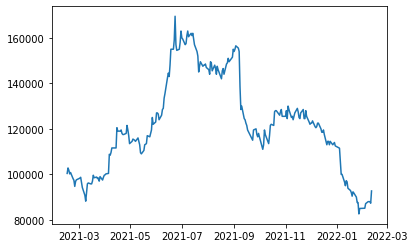

In [62]:
plt.plot(ts)

아아..... 놀랍게 떨어지고 있다.

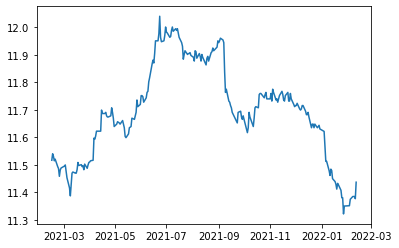

In [63]:
ts_log = np.log(ts)
plt.plot(ts_log)

### 2-2-3. 시계열 안정성 분석

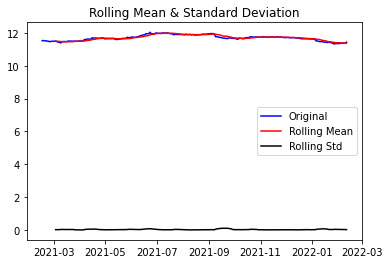

Results of Dickey-Fuller Test:
Test Statistic                  -1.836063
p-value                          0.362710
#Lags Used                       7.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


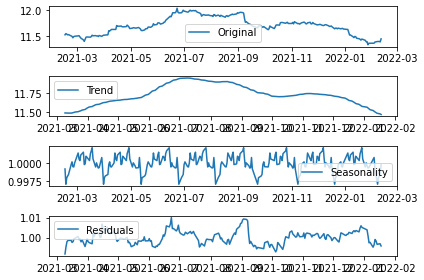

In [64]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


p-value가 0.36

하지만 ARIMA 를 이용한 Residual 은  
0.0001 값이 나와 예측 가능하다.

In [65]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.583573
p-value                          0.000138
#Lags Used                       5.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


### 2-2-4. Train, Test Split

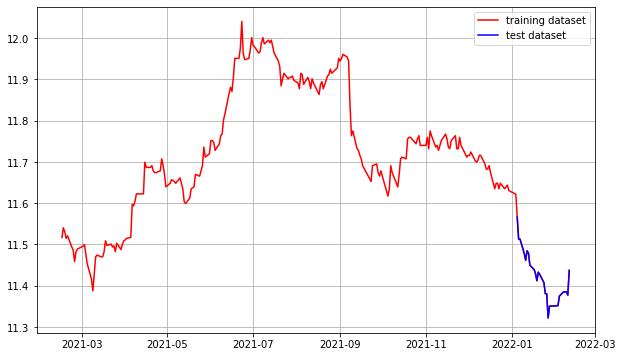

In [66]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

p, q , d 값 구하기

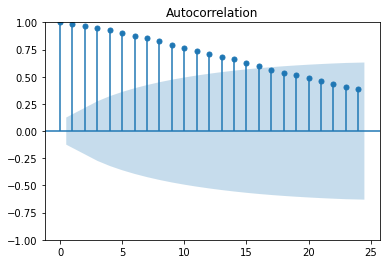

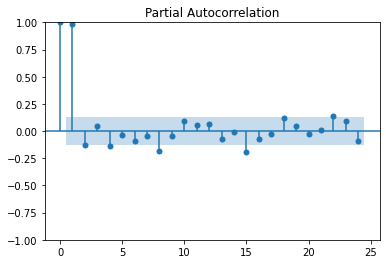

In [67]:

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -7.755638e+00
p-value                        9.754693e-12
#Lags Used                     2.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.182415e+01
p-value                        8.279255e-22
#Lags Used                     5.000000e+00
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


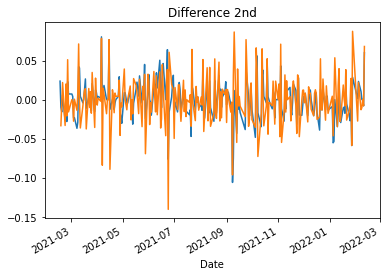

In [68]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## 2-3. 모델 학습

In [74]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 465.536
Date:                Fri, 11 Feb 2022   AIC                           -927.071
Time:                        06:29:49   BIC                           -920.293
Sample:                             0   HQIC                          -924.334
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4154      0.059     -7.033      0.000      -0.531      -0.300
sigma2         0.0008   5.73e-05     14.539      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   7.68   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


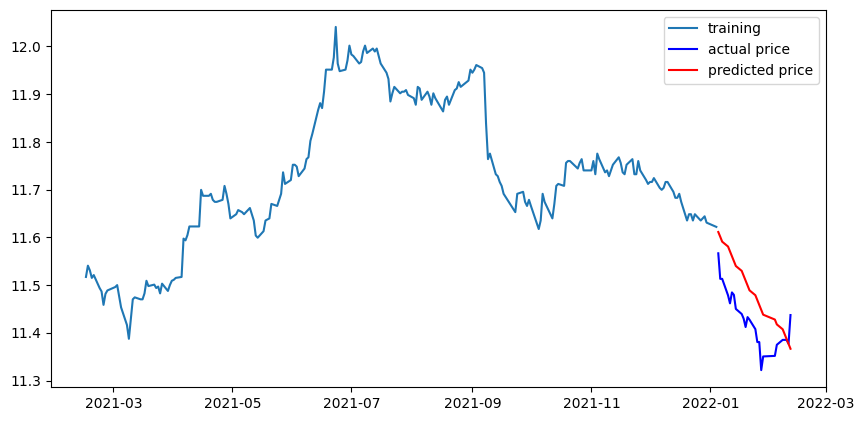

In [75]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


차분이 곧 미분이라고 의미하면 편할 것 같다.

기울기는 경향성(sesonality)을 의미한다고 경험적으로 느꼈다.

다른 지표들과 다르게  
하향곡선 상향곡선을 띌 때 예측을 한다면  
차분을 이용하면 값이 더 잘나온다고 느꼈다. 

실제로 d의 값을 2로 설정하니 원래의 그래프와 유사해졌다.

## 2-4. 데이터 평가하기

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  53867724.554702416
MAE:  6662.569495425215
RMSE:  7339.463505918019
MAPE: 7.24%


7.24% 로 적은 오차율을 보였다.

# 2.GAME#3 도미노피자

## 2-1. 데이터 불러오기

In [10]:
dataset_filepath = os.getenv('HOME')+'/aiffel/workplace/E11/stock_prediction/data/DPZ.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-11,383.269989,385.940002,380.989990,385.200012,382.017792,462100
1,2021-02-12,385.070007,388.049988,382.309998,385.170013,381.988068,355200
2,2021-02-16,386.170013,387.459991,377.679993,377.920013,374.797974,469600
3,2021-02-17,377.100006,377.100006,370.670013,376.489990,373.379761,534200
4,2021-02-18,375.670013,378.899994,374.459991,377.140015,374.024414,302900


In [11]:
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True )
ts = df['Close']

ts.head()

Date
2021-02-11    385.200012
2021-02-12    385.170013
2021-02-16    377.920013
2021-02-17    376.489990
2021-02-18    377.140015
Name: Close, dtype: float64

In [12]:
ts.tail()

Date
2022-02-04    438.070007
2022-02-07    434.359985
2022-02-08    438.730011
2022-02-09    444.760010
2022-02-10    438.579987
Name: Close, dtype: float64

## 2-2. 데이터 전처리

### 2-2-1. 결측치 제거

In [13]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

### 2-2-2. Normalization

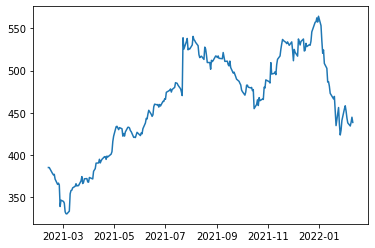

In [14]:
plt.plot(ts)

사실 최근에 도미노피자에 투자하려 했는데  
큰일날뻔했다... 후 이제 앞으로 도미노피자는 어떻게 될까? 궁금하다.

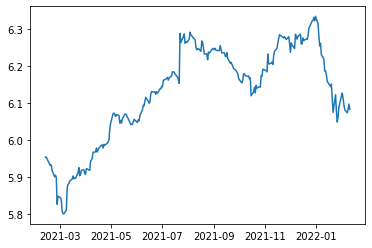

In [15]:
ts_log = np.log(ts)
plt.plot(ts_log)

### 2-2-3. 시계열 안정성 분석

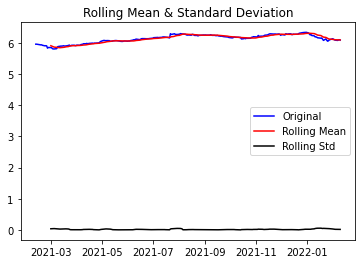

Results of Dickey-Fuller Test:
Test Statistic                  -1.439628
p-value                          0.563137
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


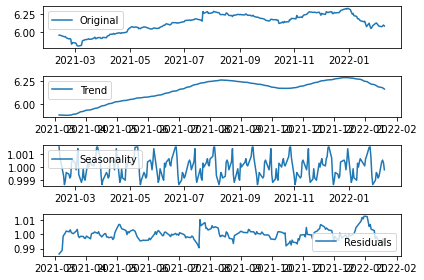

In [16]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
from statsmodels.tsa.stattools import adfuller


def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()



우선 Residual 의 p-value 는 0.00003 으로 seasonality 성질이 입증되었다.

In [17]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.899675
p-value                          0.000035
#Lags Used                       3.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


### 2-2-4. Train, test split

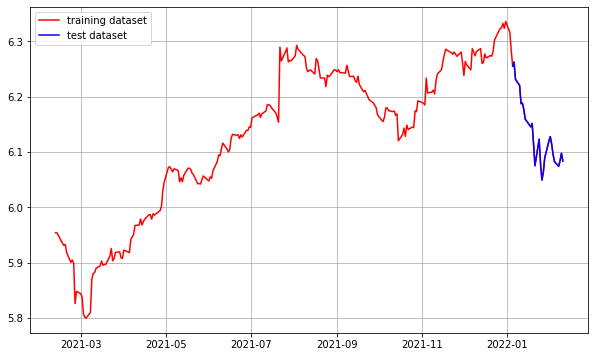

In [18]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

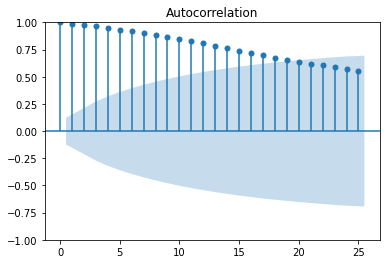

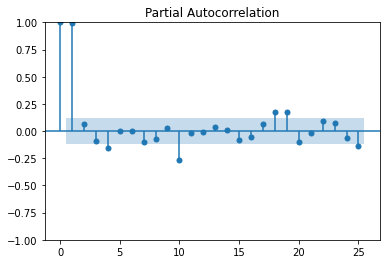

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -1.673782e+01
p-value                        1.366133e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.697694e+00
p-value                        1.093135e-16
#Lags Used                     7.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


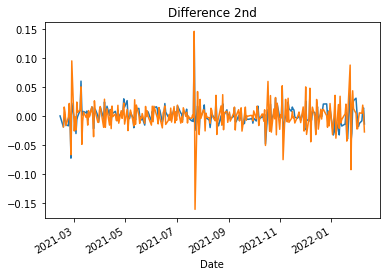

In [20]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## 2-3. 모델 학습

In [21]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(20, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                ARIMA(20, 0, 1)   Log Likelihood                 612.645
Date:                Thu, 17 Feb 2022   AIC                          -1179.290
Time:                        02:14:58   BIC                          -1100.516
Sample:                             0   HQIC                         -1147.504
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1375      0.072     84.972      0.000       5.996       6.279
ar.L1          0.5344      1.551      0.345      0.730      -2.505       3.573
ar.L2          0.4784      1.401      0.341      0.7

## 2-4. 데이터 평가

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3983.9214961268544
MAE:  59.19956884772929
RMSE:  63.11831347657235
MAPE: 13.14%


그래프가 마음에 안들긴 하지만 최소한 계속 감소추세라는 것은 맞췄다.

13.14 %로 목표로 했던 오차율 15%보다는 낮은 추세이다.

# 3. POTG
## 3-1. 소감

#### "🙄 ACF? PACF? 이게 다 무슨 소리야.."

속상한 프로그램이었습니다.. 통계기법 ARIMA 를 사용하면서 정작 이해는 전혀 못했습니다.  
피가 끓어오르는 의지로 이 기법을 이해하고 싶습니다.  
ACF , PACF 의 이용방법을 꼭 알아내고야 말겠습니다.


## 3-2. 어려웠던 점과 극복방안

### 1. p, q, d 의 사용방법

첫 소감에 적었듯이 p, q, r 에 대해 아직 완전히 이해하지 못했다.
분명 교육 중에는 이러한 문장이 있었다.

> 이들 중 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다. 

하지만, 실상 내가 삼성, 카카오, 도미노피자를 직접 연구하고 다양한 q ,p 값을 대입하면서 p + q < 2 q * q=0 이었던 적은 카카오의 경우밖에 없었고,


삼성 = ARIMA p,d,q 값  20, 0, 1  
카카오 = ARIMA p,d,q 값 1, 2, 0  
도미노 = ARIMA p,d,q 값 20, 0, 1

그래프를 통해서도 이 값을 전혀 예측할 수 없었다.

카카오의 경우 :
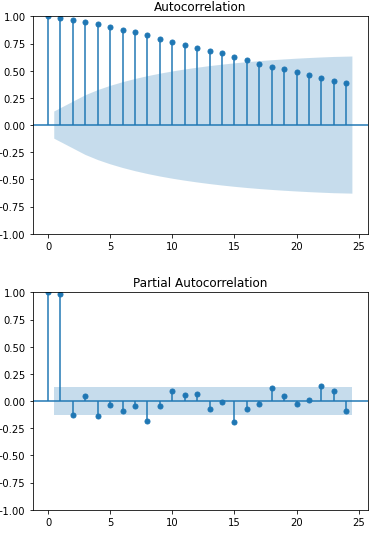

도미노의 경우 :
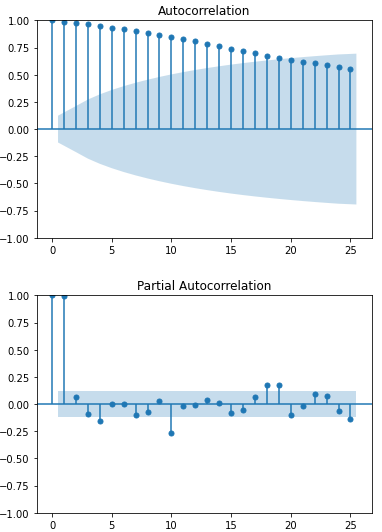

왜 이 유사한 그래프에서  
카카오는 1의 p 값을 가져야 좋은 결과가 나오고
도미노는 20의 p 값을 가져야 좋은 결과가 나오는 걸까?

의문투성이인 이 그래프를 보면서 모르느니만 못하다는 생각을 했다.

순차적인 이해와 지식이 바탕이 되어야, 그러한 지혜를 기반으로 한 예측이어야  
대중에게 이 정보를 신뢰성 있게 설파할 수 있다고 생각한다.

### 2. 정말 미래 예측
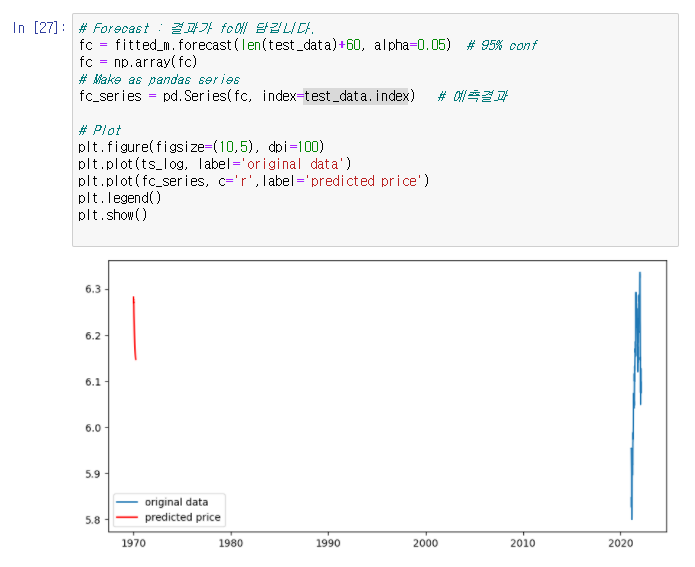

만든 예측 모델을 가지고 정말 아직 오지 않은 미래 데이터를  
보고 싶었다. 허나 잘못된 그래프가 나왔다.

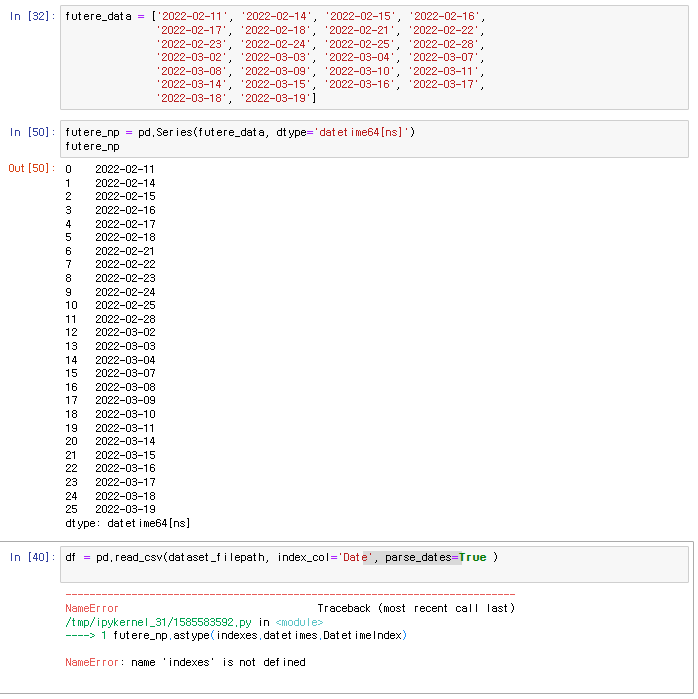
내가 찾은 문제점은 DateIndex 데이터 이다.  
내가 보고싶은 날짜가 있다면 다음 날짜의 데이터를 채워 넣어 주어야 하는데,  
DatetimeIndex 의 생성방법을 몰라 계속 실패했다.




## 3-3. 추후

이러한 속상한 결과들이 나오는 이유는

1. 통계 지식의 부족
2. 라이브러리 사용법의 부족 (pandas, metplotlib)

에 있다.  
공부할게 너~~~~~~ 무 많다.  
하지만, 주눅들지 않고 당장 한걸음 한걸음 걸어나가 보자!  

그럼 언젠가 정상에 올라가 있지 않을까

지금 나에게 필요한 눈 앞의 한걸음은  
우선 파이썬 라이브러리를 숙달하는 것이다.  
딥러닝 모델에 대해 공부하면서 틈틈히 라이브러리 이용법을 숙달하도록 한다.